In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')



In [2]:
###############################################################################
# 1. Build a spline for ln(P(0,T)) using T_i and Discount = P(0,T_i).
###############################################################################
def build_discount_spline(excel_file='capdata.xlsx'):
    """
    1) Reads market data from 'capdata.xlsx', assuming columns:
         'T_i'      : time in years to the *payment* date
         'Discount' : discount factor P(0, T_i)
       (and possibly T_iM1, tau_i, etc. for each row)

    2) Builds a cubic spline of ln(P(0,T)) vs. T, so that for
       any T' in [0, max(T_i)], we can get discount factor = exp(cs(T')).

    Returns:
       - cs    : CubicSpline object for ln(P(0,T))
       - df    : the original DataFrame (sorted by T_i) for reference
    """

    df = pd.read_excel(excel_file)

    T_array = df['T_i'].values
    P_array = df['Discount'].values  # P(0,T_i)

    lnP_array = np.log(P_array)
    cs = CubicSpline(T_array, lnP_array, bc_type='natural')
    e_cs = lambda t: np.exp(cs(t))

    return cs, df, e_cs

In [3]:
###############################################################################
# 2. Helper to get discount factor and forward from the spline
###############################################################################
def discount_spline(cs, T):
    """
    Given a spline cs of ln(P(0,T)), return discount factor P(0,T).
    T may be a scalar or a numpy array.
    """
    return np.exp(cs(T))

def forward_spline(cs, T):
    """
    f_M(T) = - d/dT ln(P(0,T)) = -cs'(T).
    """
    return -cs.derivative()(T)



In [4]:
###############################################################################
# 3. Hull-White Caplet formula
###############################################################################
def caplet_HullWhite(strike, notional, tau, T_reset, P_T, P_S, a, sigma):
    """
    Price of a single caplet under Hull-White with reset at T_reset and payment at T_reset + tau.

    strike : decimal
    notional : float
    tau : accrual fraction
    T_reset : time in years to the start of the accrual
    P_T : discount factor P(0, T_iM1) i.e. P(0,T_reset)
    P_S : discount factor P(0, T_i)
    a, sigma : HW parameters
    """
    # Transform payoff
    X_new = 1.0 / (1.0 + strike * tau)
    N_new = notional * (1.0 + strike * tau)

    # B(tau)
    B = (1.0 - np.exp(-a * tau)) / a

    # sigma_p
    sigma_p = sigma * np.sqrt((1.0 - np.exp(-2.0 * a * T_reset)) / (2.0 * a)) * B

    # h
    # log((P_S / P_T)/X_new) => log((P_S / P_T) * 1/X_new)
    # The sign conventions come from the standard Jamshidian/HW formula
    h = (1.0 / sigma_p) * np.log((P_S / P_T) / X_new) + (sigma_p / 2.0)

    # final price
    price = N_new * (
        X_new * P_T * stats.norm.cdf(-h + sigma_p)
        - P_S * stats.norm.cdf(-h)
    )
    return price



In [5]:
###############################################################################
# 4. Summation over a set of caplets
###############################################################################
def price_caplets_HW(r0, a, sigma,
                     T_reset_array, tau_array, strike_array, notional_array,
                     discount_cs):
    """
    For each caplet j:
      - reset time = T_reset_array[j] i.e. T_jM1
      - payment time = T_reset_array[j] + tau_array[j] i.e. T_j
      - discount factors from the spline (interpolate)
    """
    n = len(T_reset_array)
    results = np.zeros(n)

    for j in range(n):
        T_reset_j = T_reset_array[j]
        tau_j = tau_array[j]
        strike_j = strike_array[j]
        N_j = notional_array[j]

        # discount factors for reset & payment
        P_T = discount_spline(discount_cs, T_reset_j)
        P_S = discount_spline(discount_cs, T_reset_j + tau_j)

        # Price single caplet
        results[j] = caplet_HullWhite(strike_j, N_j, tau_j, T_reset_j, P_T, P_S, a, sigma)

    return results



In [6]:
###############################################################################
# 5. Calibration objective
###############################################################################
def objective_hw(x,
                 market_caplet_prices,
                 T_reset_array, tau_array, strike_array, notional_array,
                 discount_cs,
                 objective_type='caplet'):
    """
    x = [r0, a, sigma]
    Returns sum of squared differences between model and market prices.
    If objective_type='cap', we sum caplets to compare total 'cap' price.
    """
    r0, a, sigma = x

    model_prices = price_caplets_HW(r0, a, sigma,
                                    T_reset_array, tau_array, strike_array, notional_array,
                                    discount_cs)
    if objective_type == 'cap':
        # sum them up for a full 'cap' price vs the sum of market caplets
        sum_model = np.cumsum(model_prices)
        sum_market = np.cumsum(market_caplet_prices)
        mse = np.sum((sum_model - sum_market)**2)
    else:
        # compare each caplet individually
        mse = np.sum((model_prices - market_caplet_prices)**2)

    return mse




In [7]:
def HW_ZBPut_MC_Q(r0, a, sigma, T, S, X, discount_cs, n_paths=100000, dt=0.01):
    steps = int(T / dt)
    r = np.zeros((n_paths, steps + 1))
    r[:, 0] = r0
    t_grid = np.linspace(0, T, steps + 1)

    def alpha(t):
        f_t = forward_spline(discount_cs, t)
        dfdt = -discount_cs.derivative(2)(t)
        return dfdt + a * f_t + (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * t))

    for i in range(steps):
        t = t_grid[i]
        Z = np.random.normal(size=n_paths)
        drift = -a * r[:, i] + alpha(t)
        r[:, i + 1] = r[:, i] + drift * dt + sigma * np.sqrt(dt) * Z

    r_T = r[:, -1]

    def B(t, T): return (1 - np.exp(-a * (T - t))) / a
    def A(t, T):
        tau = T - t
        return np.exp((sigma ** 2 / (2 * a ** 2)) *
                      (tau - (1 - np.exp(-a * tau)) / a - 0.5 * (1 - np.exp(-a * tau)) ** 2 / a))

    PTS = A(T, S) * np.exp(-B(T, S) * r_T)
    payoff = np.maximum(X - PTS, 0)

    integral_r = np.sum(r[:, :-1], axis=1) * dt
    discount = np.exp(-integral_r)

    return np.mean(discount * payoff)


In [8]:
def HW_ZBPut_MC_T(r0, a, sigma, T, S, X, discount_cs, n_paths=100000, dt=0.01):
    steps = int(T / dt)
    r = np.zeros((n_paths, steps + 1))
    r[:, 0] = r0
    t_grid = np.linspace(0, T, steps + 1)

    def B(t, T): return (1 - np.exp(-a * (T - t))) / a
    def A(t, T):
        tau = T - t
        return np.exp((sigma ** 2 / (2 * a ** 2)) *
                      (tau - (1 - np.exp(-a * tau)) / a - 0.5 * (1 - np.exp(-a * tau)) ** 2 / a))

    for i in range(steps):
        t = t_grid[i]
        theta_T = r0 * a + (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * t)) + sigma * B(t, T)
        Z = np.random.normal(size=n_paths)
        r[:, i + 1] = (
            r[:, i] * np.exp(-a * dt)
            + theta_T * (1 - np.exp(-a * dt))
            + sigma * np.sqrt((1 - np.exp(-2 * a * dt)) / (2 * a)) * Z
        )

    r_T = r[:, -1]
    PTS = A(T, S) * np.exp(-B(T, S) * r_T)
    payoff = np.maximum(X - PTS, 0)
    P0T = discount_spline(discount_cs, T)

    return P0T * np.mean(payoff)


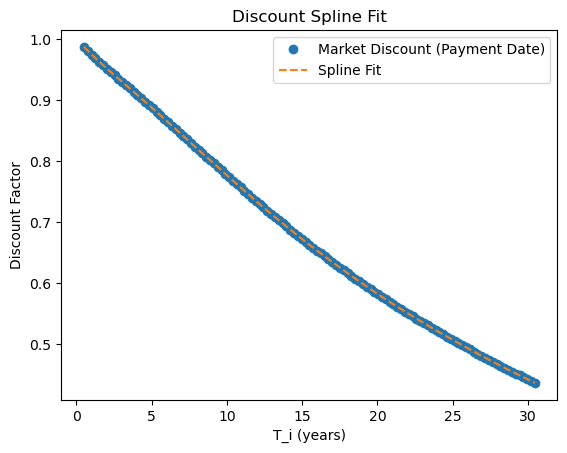

`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 104, CG iterations: 51, optimality: 2.45e+05, constraint violation: 0.00e+00, execution time: 0.58 s.
=== Calibration Results ===
Optimal [r0, a, sigma]: [0.02543754 0.00477074 0.00638713]
Success: True
Message: `xtol` termination condition is satisfied.
Objective (SSE): 76173594.27483262


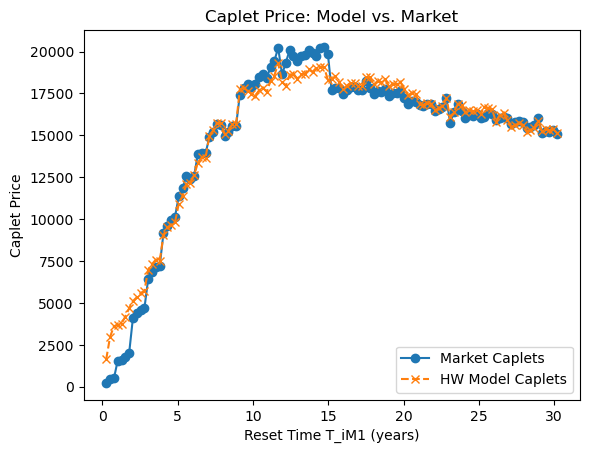

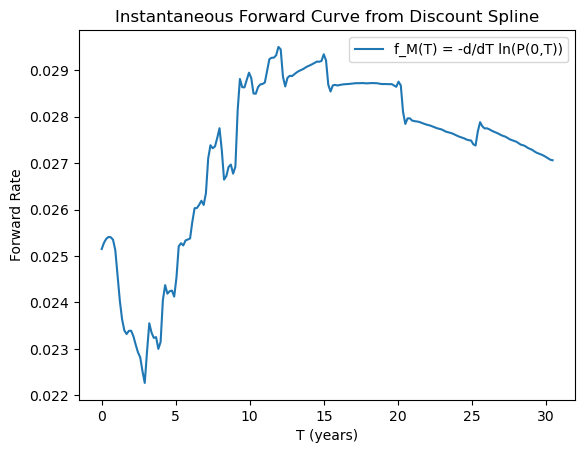

[DONE]


In [9]:
###############################################################################
# 6. Example usage
###############################################################################
if __name__ == "__main__":

    # Step A: Build the discount spline from T_i & Discount
    discount_cs, df_data,e_cs = build_discount_spline('/Users/sphaela/Downloads/capdata.xlsx')

    # Quick check: see how well the spline fits
    T_i_array = df_data['T_i'].values
    P_i_array = df_data['Discount'].values
    P_fit = discount_spline(discount_cs, T_i_array)

    plt.figure()
    plt.plot(T_i_array, P_i_array, 'o', label='Market Discount (Payment Date)')
    plt.plot(T_i_array, P_fit, '--', label='Spline Fit')
    plt.xlabel("T_i (years)")
    plt.ylabel("Discount Factor")
    plt.title("Discount Spline Fit")
    plt.legend()
    plt.show()

    # Step B: Pull out the relevant columns for caplets

    T_reset_array = df_data['T_iM1'].values       # reset times in years
    tau_array     = df_data['tau_i'].values       # accrual fractions
    strike_array  = df_data['CapStrike'].values / 100
    notional_array = df_data['Notional']
    market_caplet_prices = df_data['PV'].values

    # Step C: Provide an initial guess for [r0, a, sigma]
    # For example, r0 from the short end of the discount curve:
    # let's pick the smallest T_i to approximate short rate
    idx_min = np.argmin(T_i_array)
    T_min   = T_i_array[idx_min]
    P_min   = P_i_array[idx_min]
    r0_init = -np.log(P_min)/T_min
    a_init = 0.1
    sigma_init = 0.01
    x0 = [r0_init, a_init, sigma_init]

    # Step D: Calibrate
    from scipy.optimize import minimize

    args = (market_caplet_prices,
            T_reset_array,
            tau_array,
            strike_array,
            notional_array,
            discount_cs,
            'caplet')  # or 'cap' if you want to sum

    res = minimize(objective_hw,
                   x0,
                   args=args,
                   method='trust-constr',
                   options={'disp': True})

    print("=== Calibration Results ===")
    print("Optimal [r0, a, sigma]:", res.x)
    print("Success:", res.success)
    print("Message:", res.message)
    print("Objective (SSE):", res.fun)

    # Step E: Compare model vs market
    r0_opt, a_opt, sigma_opt = res.x
    model_prices = price_caplets_HW(r0_opt, a_opt, sigma_opt,
                                    T_reset_array, tau_array, strike_array, notional_array,
                                    discount_cs)

    plt.figure()
    plt.plot(T_reset_array, market_caplet_prices, 'o-', label='Market Caplets')
    plt.plot(T_reset_array, model_prices, 'x--', label='HW Model Caplets')
    plt.xlabel("Reset Time T_iM1 (years)")
    plt.ylabel("Caplet Price")
    plt.title("Caplet Price: Model vs. Market")
    plt.legend()
    plt.show()

    # (Optional) Plot the forward curve from the discount spline
    T_grid = np.linspace(0, max(T_i_array), 200)
    f_grid = forward_spline(discount_cs, T_grid)
    plt.figure()
    plt.plot(T_grid, f_grid, label='f_M(T) = -d/dT ln(P(0,T))')
    plt.xlabel("T (years)")
    plt.ylabel("Forward Rate")
    plt.title("Instantaneous Forward Curve from Discount Spline")
    plt.legend()
    plt.show()

    print("[DONE]")

In [10]:
def ZCB_put_analytical(r0, a, sigma, T, S, X, P0_T, P0_S):
    B_TS = (1 - np.exp(-a * (S - T))) / a
    sigma_P = sigma * np.sqrt((1 - np.exp(-2*a*T)) / (2*a)) * B_TS
    ln_PTS_mean = np.log(P0_S / P0_T)

    d1 = (ln_PTS_mean - np.log(X)) / sigma_P + 0.5 * sigma_P
    d2 = d1 - sigma_P

    put_price = X * norm.cdf(-d2) - (P0_S / P0_T) * norm.cdf(-d1)
    return P0_T * put_price

In [19]:
from scipy.stats import norm
df = pd.read_excel('/Users/sphaela/Downloads/capdata.xlsx')
pts_list = []
anal = []
for i in range(len(T_reset_array)):
    T = T_reset_array[i]
    tau = tau_array[i]
    S = T + tau
    X = np.exp(-r0_opt * (S - T))

    black = ZCB_put_analytical(r0_opt, a_opt, sigma_opt, T, S, X, e_cs(T), e_cs(S))
    anal.append(black)
    
    pts = HW_ZBPut_MC_Q(
        r0_opt, a_opt, sigma_opt,
        T, S,X,
        discount_cs,
        n_paths=10000
    )
    pts_list.append(pts)
    

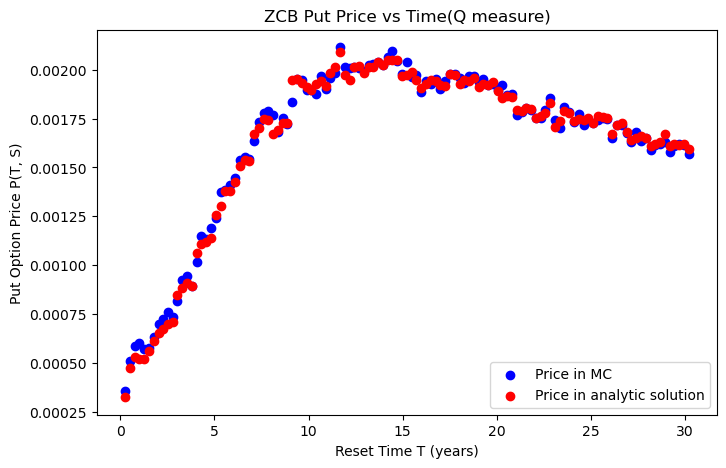

In [20]:
plt.figure(figsize=(8, 5))
plt.scatter(T_reset_array, pts_list, color='blue', label='Price in MC', marker='o')
plt.scatter(T_reset_array, anal, color='red', label='Price in analytic solution', marker='o')
plt.xlabel('Reset Time T (years)')
plt.ylabel('Put Option Price P(T, S)')
plt.title('ZCB Put Price vs Time(Q measure)') 
plt.legend()
plt.show()



In [39]:
from scipy.stats import norm

def ZCB_put_analytical_T(r0, T, S, a, sigma, P0_T, P0_S, X):

    B = (1 - np.exp(-a * (S - T))) / a
    A = (P0_S / P0_T) * np.exp(
        (sigma ** 2 / (2 * a ** 2)) *
        ((S - T) - (1 - np.exp(-a * (S - T))) / a - 0.5 * (1 - np.exp(-a * (S - T))) ** 2 / a)
    )

    sigma_P = sigma * B * np.sqrt((1 - np.exp(-2 * a * T)) / (2 * a))
    d = (np.log(A / X) - B * r0) / sigma_P

    price = P0_T * (X * norm.cdf(-d) - A * norm.cdf(-d + sigma_P))
    return price


In [43]:
pts_list_T = []
anal_T = []

for i in range(len(T_reset_array)):
    T = T_reset_array[i]
    tau = tau_array[i]
    S = T + tau

    P0_T = e_cs(T)
    P0_S = e_cs(S)
    X = 1.05 * P0_S / P0_T

    price_analytical = ZCB_put_analytical_T(r0_opt, T, S, a_opt, sigma_opt, P0_T, P0_S, X)
    anal_T.append(price_analytical)

    price_mc = HW_ZBPut_MC_T(r0_opt, a_opt, sigma_opt,T, S, X,discount_cs,n_paths=10000)
    pts_list_T.append(price_mc)


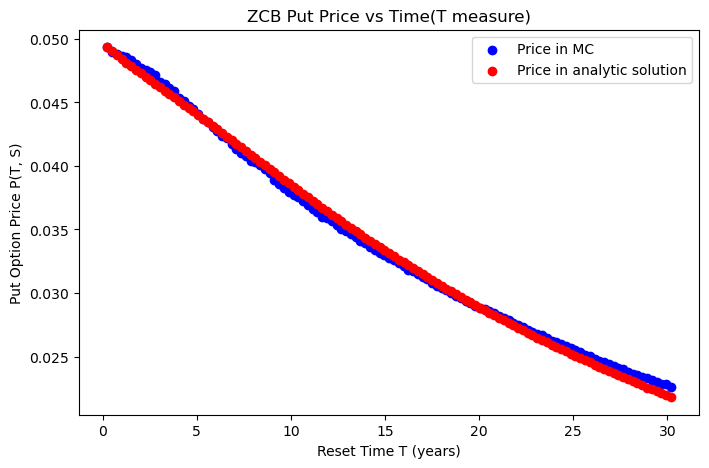

In [47]:
plt.figure(figsize=(8, 5))
plt.scatter(T_reset_array, pts_list_T, color='blue', label='Price in MC', marker='o')
plt.scatter(T_reset_array, anal_T, color='red', label='Price in analytic solution', marker='o')
plt.xlabel('Reset Time T (years)')
plt.ylabel('Put Option Price P(T, S)')
plt.title('ZCB Put Price vs Time(T measure)')
plt.legend()
plt.show()